# Exercise: Implement quantization-aware training in TensorFlow

In-training quantization (or Quantization Aware Training - QAT) is like teaching someone a new skill while using the tools they'll actually have—similar to training an athlete at high altitude when they'll compete there, not at sea level. The model learns to perform well with quantized weights and activations right from the start.

> **Overview**: We'll apply quantization aware training to an image classification model, allowing it to learn how to maintain accuracy despite reduced numerical precision. This technique produces models that excel when deployed on hardware optimized for integer operations.
> 
> **Goal**: Implement QAT to create highly optimized integer models that can achieve peak performance on specialized hardware and potentially recover subtle accuracy losses compared to post-training quantization methods.
> 
> **Scenario**: You work for a wildlife conservation organization deploying smart camera traps in remote areas (same as for Lesson 2). These battery-powered cameras need to identify different animal species locally to prioritize important footage for transmission back to base via limited satellite connectivity. Your team has a pre-trained MobileNetV2 model that accurately identifies local species for which they have applied post-training quantization (PQT). While the model works well in testing, field deployment faces two critical challenges:
>    1. _On-device performance gap_: While PTQ models were fast, on the *actual camera trap hardware*, which features a specialized Neural Processing Unit (NPU) optimized for 8-bit integer (INT8) operations, the team believes even greater latency reduction and power efficiency are achievable if the model is *perfectly* conditioned for INT8.
>    2. _Accuracy improvements for critical cases_: For a newly discovered and extremely rare bird species, which shares very subtle visual features with a common one, the PTQ INT8 model showed a tiny, but critical, dip in distinguishing accuracy compared to the float TFLite model.
> 
> Your team has selected Quantization Aware Training (QAT) as the next step. By training with simulated quantization, the model will learn to be robust to INT8 constraints while maintaining critical accuracy for rare species identification.
> 
> **Tools**: TensorFlow, TensorFlow Model Optimization Toolkit, LiteRT, MobileNetV2, Matplotlib.
> 
> **Estimated Time**: 15 minutes

**⚠️ NOTE**: We skip model accuracy benchmarking for this demo to focus on the technique only, please feel free to expand!

## Step 1: Setup
Let's begin by importing the necessary libraries and setting up our environment.

In [1]:
# # Uncomment to install necessary libraries, then comment out the cell block again and restart the notebook
# ! pip install 'tensorflow[and-cuda]' datasets tensorflow_datasets tensorflow-model-optimization tf_keras tflite_runtime

In [2]:
# Set environment variables for TensorFlow for the session
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Avoid logging info and warnings
os.environ['TF_USE_LEGACY_KERAS'] = '1'  # Ensure tf_keras is used for compatibility with tensorflow-model-optimization

In [3]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import tempfile
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot

# Set up plotting
plt.style.use('ggplot')

# Set random seed for deterministic results
os.environ['PYTHONHASHSEED']=str(2)
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

# Create output directory
output_dir = "assets/exercise1"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print("Setup complete!")

2025-05-12 09:40:20.157190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747042820.791406     539 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747042821.012478     539 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747042823.183656     539 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747042823.183713     539 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747042823.183717     539 computation_placer.cc:177] computation placer alr

Setup complete!


> **Environment configuration**: We set `TF_USE_LEGACY_KERAS=1` to ensure compatibility with the TensorFlow Model Optimization toolkit, which may not yet fully support Keras 3.0. Setting random seeds ensures reproducible results across runs.
> 
> **About those warnings**: The CUDA-related warnings (cuFFT, cuDNN, cuBLAS) appear because TensorFlow is attempting to register GPU libraries multiple times for the multiple TensorFlow components that are loaded  - this is harmless and won't affect your model training. 

## Step 2: Load the pre-trained model
We'll load a MobileNetV2 model pre-trained on ImageNet. 

If the scenario was real, this would be your custom-trained wildlife classification model that has already undergone initial evaluations.

In [4]:
# Load a pre-trained MobileNetV2 model
input_shape = (224, 224, 3)
base_model = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=True)

# Save the original model for comparison
original_model_path = os.path.join(output_dir, "mobilenetv2_original.keras")
base_model.save(original_model_path)

# Get some model information
print(f"Original MobileNetV2 model saved to {original_model_path}")
base_model.summary()

I0000 00:00:1747042838.410954     539 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Original MobileNetV2 model saved to assets/exercise1/mobilenetv2_original.keras
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  

                                                                                                  
 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormaliz

                                                                                                  
 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_p

 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_

 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
          

 block_16_depthwise (Depthw  (None, 7, 7, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
          

> **A look at the model architecture**: The repeating "block_X" patterns reveal MobileNetV2's inverted residual structure. These blocks expand channels internally (up to 960) before projecting back to smaller dimensions (96-160), enabling rich feature extraction within memory constraints.
> 
> _For further exploration_, you could execute `[layer.name for layer in base_model.layers if 'expand' in layer.name]` to identify expansion layers, or use `tf.keras.utils.plot_model(base_model, show_shapes=True)` to visualize the bottleneck architecture. This expansion-projection pattern explains how a 13MB model achieves high accuracy—critical for resource-limited wildlife camera deployments.

## Step 3: Define the quantization-aware model
Now we'll apply quantization-aware training. This step modifies the model to simulate quantization during the forward pass while maintaining full precision during backpropagation.

In [5]:
# TODO: Apply quantization aware training to the base_model.
# Hint: Look for built-in functionalities in tensorflow-model-optimization. 
# Documentation is at https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/quantization/keras.
q_aware_model = tfmot.quantization.keras.quantize_model(base_model)  # Add your code here

print("Quantization-aware model created!")
print("New layers added for fake quantization during training.")

# TODO: Compile the quantization-aware model with appropriate settings (loss, optimizer, metrics, ...)
q_aware_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])  # Add your code here

print("Quantization-aware model created and compiled.")

# Let's examine the structure - you'll see new QuantizeLayer components
q_aware_model.summary()

Quantization-aware model created!
New layers added for fake quantization during training.
Quantization-aware model created and compiled.
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 quantize_layer (QuantizeLa  (None, 224, 224, 3)          3         ['input_1[0][0]']             
 yer)                                                                                             
                                                                                                  
 quant_Conv1 (QuantizeWrapp  (None, 112, 112, 32)         929       ['quantize_layer[0][0]']      
 erV2)                                   

 QuantizeWrapperV2)                                                 ]                             
                                                                                                  
 quant_block_2_add (Quantiz  (None, 56, 56, 24)           3         ['quant_block_1_project_BN[0][
 eWrapperV2)                                                        0]',                          
                                                                     'quant_block_2_project_BN[0][
                                                                    0]']                          
                                                                                                  
 quant_block_3_expand (Quan  (None, 56, 56, 144)          3745      ['quant_block_2_add[0][0]']   
 tizeWrapperV2)                                                                                   
                                                                                                  
 quant_blo

                                                                                                  
 quant_block_5_project_BN (  (None, 28, 28, 32)           131       ['quant_block_5_project[0][0]'
 QuantizeWrapperV2)                                                 ]                             
                                                                                                  
 quant_block_5_add (Quantiz  (None, 28, 28, 32)           3         ['quant_block_4_add[0][0]',   
 eWrapperV2)                                                         'quant_block_5_project_BN[0][
                                                                    0]']                          
                                                                                                  
 quant_block_6_expand (Quan  (None, 28, 28, 192)          6529      ['quant_block_5_add[0][0]']   
 tizeWrapperV2)                                                                                   
          

 ntizeWrapperV2)                                                    [0][0]']                      
                                                                                                  
 quant_block_8_project_BN (  (None, 14, 14, 64)           259       ['quant_block_8_project[0][0]'
 QuantizeWrapperV2)                                                 ]                             
                                                                                                  
 quant_block_8_add (Quantiz  (None, 14, 14, 64)           3         ['quant_block_7_add[0][0]',   
 eWrapperV2)                                                         'quant_block_8_project_BN[0][
                                                                    0]']                          
                                                                                                  
 quant_block_9_expand (Quan  (None, 14, 14, 384)          25345     ['quant_block_8_add[0][0]']   
 tizeWrapp

 (QuantizeWrapperV2)                                                ']                            
                                                                                                  
 quant_block_11_add (Quanti  (None, 14, 14, 96)           3         ['quant_block_10_project_BN[0]
 zeWrapperV2)                                                       [0]',                         
                                                                     'quant_block_11_project_BN[0]
                                                                    [0]']                         
                                                                                                  
 quant_block_12_expand (Qua  (None, 14, 14, 576)          56449     ['quant_block_11_add[0][0]']  
 ntizeWrapperV2)                                                                                  
                                                                                                  
 quant_blo

 quant_block_14_project_BN   (None, 7, 7, 160)            643       ['quant_block_14_project[0][0]
 (QuantizeWrapperV2)                                                ']                            
                                                                                                  
 quant_block_14_add (Quanti  (None, 7, 7, 160)            3         ['quant_block_13_project_BN[0]
 zeWrapperV2)                                                       [0]',                         
                                                                     'quant_block_14_project_BN[0]
                                                                    [0]']                         
                                                                                                  
 quant_block_15_expand (Qua  (None, 7, 7, 960)            155521    ['quant_block_14_add[0][0]']  
 ntizeWrapperV2)                                                                                  
          

> **How QAT works**: Notice how every layer now has a "quant_" prefix? When you make your model quantization-aware, you wrap each layer with fake quantization operations that simulate INT8 behavior (i.e., reducing precision) during training (but only in the forward pass!) to allow the model to learn weights that are robust to quantization. 
> <br> _Important_: Look at the parameter counts - Conv1 went from 864 to 929 parameters, indicating the wrapper adds quantization metadata.  The `quantize_layer` at the input and the per-layer parameter increases (typically +3 for quantization parameters) show how comprehensively the model has been prepared for INT8 training.
> 
> **Why open-source frameworks are so important**: Without automated tools, you'd need to manually insert quantization operations after every weight computation and activation function throughout the entire network - potentially 100+ insertion points in MobileNetV2. Each would require careful calibration to avoid breaking the model's numerical stability. Thank you, open-source!

## Step 4: Train (Fine-tune) the quantization-aware model
With QAT, we typically fine-tune a pre-trained model for a few epochs on the original training set of the baseline model. The model learns to adjust its weights to minimize accuracy loss from quantization. 

### Load and prepare the data

For this exercise, we'll use an animal classification dataset called [Animal_Image_Classification](https://github.com/AlvaroVasquezAI/Animal_Image_Classification) as a proxy for wildlife camera trap data. For this scenario, data would be in higher quantity and also of higher resolution!

In [6]:
# Load and shuffle the dataset
print("Loading the data...")
dataset = load_dataset("AlvaroVasquezAI/Animal_Image_Classification_Dataset")["train"]
dataset = dataset.shuffle(seed=42)

# Split in train, test, and validation
print("Splitting the processed dataset into train, test, and validation...")
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_data = dataset.select(range(0, train_size))
val_data = dataset.select(range(train_size, train_size + val_size))
test_data = dataset.select(range(train_size + val_size, total_size))

# Convert and preprocess datasets
batch_size = 32
def preprocess(entry, label):
    image = tf.image.resize(entry['image'], (224, 224))  # Matches MobileNetV2's expected input
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  # Applies ImageNet's normalization stats to keep inputs in the same distribution the model originally learned
    return image, label

def convert_to_tf_dataset(hf_data, batch_size=batch_size):
    ds = hf_data.to_tf_dataset(columns=["image", "label"], label_cols="label")
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Converting and preprocessing splits...")
train_dataset = convert_to_tf_dataset(train_data)
val_dataset = convert_to_tf_dataset(val_data)
test_dataset = convert_to_tf_dataset(test_data)

# Check the sizes of the datasets
print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

Loading the data...
Splitting the processed dataset into train, test, and validation...
Converting and preprocessing splits...
Train size: 2400, Val size: 300, Test size: 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Image shape: (224, 224, 3)


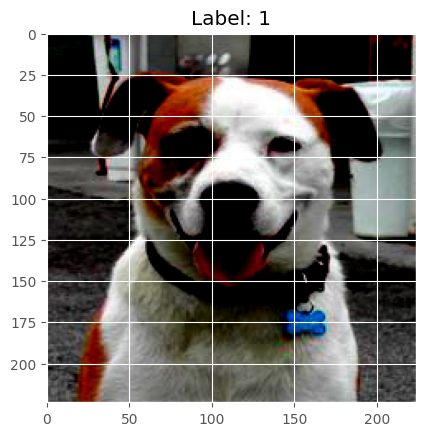

In [7]:
# Visualize a sample
for (images, labels) in test_dataset.take(1):
    # Extract first image and label from batch
    image, label = images[0], labels[0]
    
    # Get image shape
    print("Image shape:", image.shape)

    # Convert the image from tensor to numpy array for visualization
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.show()
    
    break  # Stop after the first batch

> **Data preprocessing with TensorFlow**: The `.prefetch()` and parallel mapping ensure your GPU never waits for data - critical when training with quantization overhead. `tf.data` provides other cool performance optimization options, if you're interested to [learn more](https://www.tensorflow.org/guide/data_performance)!

### Train the model with QAT
Training will be very short here—it's just an exercise aimed to demonstrate the technique, so definetely not deployment-ready! Real QAT fine-tuning might take longer and require careful hyperparameter tuning.

Training QAT model with 2400 training samples...
Epoch 1/3


I0000 00:00:1747037200.840482     228 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747037206.946013     228 service.cc:152] XLA service 0x7a60f0ba1b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747037206.946122     228 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747037207.828623     228 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 [==============================] - 173s 2s/step - loss: 0.5433 - accuracy: 0.8637 - val_loss: 10.1124 - val_accuracy: 0.3167
Epoch 2/3
75/75 [==============================] - 127s 2s/step - loss: 0.2573 - accuracy: 0.9008 - val_loss: 10.9320 - val_accuracy: 0.3400
Epoch 3/3
75/75 [==============================] - 127s 2s/step - loss: 0.2341 - accuracy: 0.9058 - val_loss: 3.5586 - val_accuracy: 0.5733
QAT model fine-tuning complete.


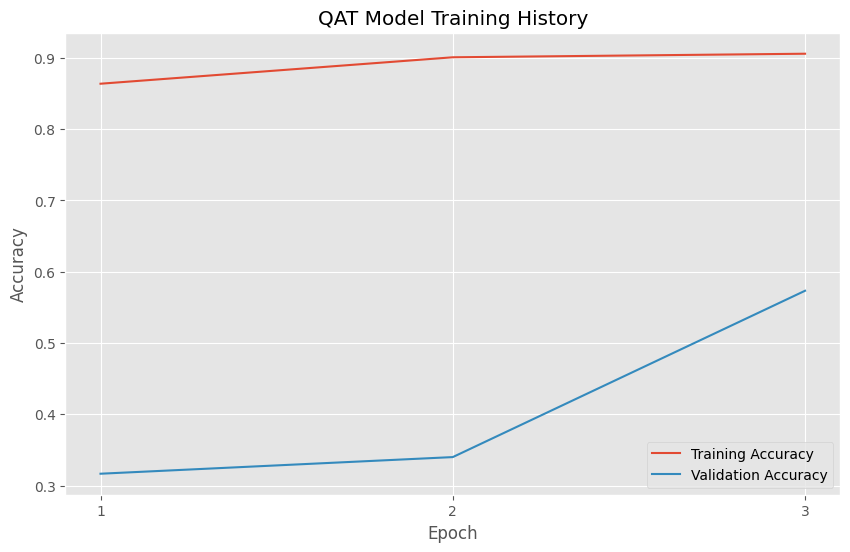

In [8]:
print(f"Training QAT model with {train_size} training samples...")
# TODO: Train (fine-tune) the q_aware_model with quantization awareness.
# Hint: Use the `fit` method with some desired parameters (don't worry if model performance is not great!)
# Do keep a low epochs count (3-5) as each epoch takes 2-3 minutes to complete.
history = q_aware_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    verbose=1
)  # Add your code here

print("QAT model fine-tuning complete.")

# Save model
model_save_path = os.path.join(output_dir, "mobilenetv2_qat.h5")
q_aware_model.save(model_save_path)

# Plot training accuracy
# TODO: Add the number of epochs you have trained for; expected an integer.
num_epochs = 3  # Add your value here
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('QAT Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(ticks=range(num_epochs), labels=[str(i + 1) for i in range(num_epochs)])  # Re-label to start from 1 rather than 0
    plt.legend()
    plt.show()

> **What can you notice from the training**: We are running into a classic transfer learning problem: training accuracy quickly skyrockets while validation lag (i.e., model is overfitting). With more epochs, the model would learn to better adapt to quantization for our specific task. 
> <br> Also, the first epoch takes longer (173s vs 127s). Why? XLA compilation and quantization graph optimization
> 
> _**Don't worry about fixing it! Just take some time to think about what would be best to do.**_

## Step 5: Convert to a LiteRT model
After QAT, the model is ready to be converted into a LiteRT model. 

In [8]:
print("Converting model to Tensorflow")

# Load the saved QAT model
model_save_path = os.path.join(output_dir, "mobilenetv2_qat.h5")
with tfmot.quantization.keras.quantize_scope():
    q_aware_model = tf.keras.models.load_model(model_save_path)

# TODO: Create a TFLiteConverter from the saved q_aware_model.
# Hint: Review LiteRT documentation at https://ai.google.dev/edge/api/tflite/python/tf/lite
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)  # Add your code here

# TODO: Set up the converter arguments as desired (optimizations, inference_input_type, ...)
# Hint: You have to set up `converter.optimizations` and `converted.representative_dataset` at minimum.
# For the latter, we provide a skeleton for the function for you to complete. 
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Add your code here

def representative_dataset_gen():
    # Add your code here as one-line for each missing step
    for image, label in val_dataset.take(1):   # 1. Iterate through 1 batch of images from the dataset (in practice, you'd use more!)
        image, label = preprocess({'image': image}, label)  # 2. Apply the same preprocessing used during training
        # image = tf.expand_dims(image, axis=0)    # 3. [If required] Add batch dimension (model expects shape [1, 224, 224, 3])
        
        # 4. Ensure the image shape is correct for the model
        assert image.shape == (batch_size, 224, 224, 3), f"Expected shape ({batch_size}, 224, 224, 3), got {image.shape}"
        
        yield [image.numpy()]                    # 5. Yield input (as required by TFLite!)

converter.representative_dataset = representative_dataset_gen

# Convert the model
tflite_qat_model = converter.convert()

# Save the QAT TFLite model
tflite_qat_model_path = os.path.join(output_dir, "mobilenetv2_qat.tflite")
with open(tflite_qat_model_path, 'wb') as f:
    f.write(tflite_qat_model)

print(f"QAT TFLite model saved to {tflite_qat_model_path}")

Converting model to Tensorflow
INFO:tensorflow:Assets written to: /tmp/tmpmezf55g8/assets


INFO:tensorflow:Assets written to: /tmp/tmpmezf55g8/assets
W0000 00:00:1747042912.201511     539 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747042912.201612     539 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1747042912.619222     539 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


QAT TFLite model saved to assets/exercise1/mobilenetv2_qat.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


> **Why is the representative dataset needed?**: If you tried without it, the converter would crash. That's because the final TFLite conversion still must determine exact INT8 ranges for any remaining float operations, activation functions, and layer outputs that have not been fully quantized during QAT training (e.g., softmax or custom layers). The converter needs actual data flowing through the model to calculate these ranges - without it, it encounters null/invalid tensors and fails.
>
> **Understanding the warnings**: The TensorFlow warnings are ok to ignore. `Ignored output_format`, `Ignored drop_control_dependency` and `MLIR V1 optimization pass` indicate setting that are ignored in the conversion process, which is ok if we're not actively configuring them.  
> After conversion, TensorFlow logs the input and output format too. If you don't specify `inference_input_type` and `inference_output_type` in your conversion, these would be FLOAT32.

## Step 6: Run inference with the QAT model
Let's test our INT8 model to ensure it loads correctly and examine its properties.

In practice, we'd need to run a full evaluation of the `.tflite` model across all metrics, ideally on the target device.

In [10]:
# Define the lite interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_qat_model_path)

# TODO: Allocate tensors for the interpreter
# Hint: Check the interpreter's documentation at https://ai.google.dev/edge/api/tflite/python/tf/lite/Interpreter
interpreter.allocate_tensors()  # Add your code here

# Get input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print("\nQAT TFLite Model Input Details:", input_details)
print("QAT TFLite Model Output Details:", output_details)

# Test inference with a sample input
# If input_details['dtype'] is int8, we need to derive the scale and zero-point from the quantization parameters
# to make the input into the int8 range [-128, 127]
if input_details['dtype'] == np.int8:
    # For INT8 input, we need to quantize our test data
    scale = input_details['quantization'][0]
    zero_point = input_details['quantization'][1]
    print(f"\nQuantization parameters - Scale: {scale}, Zero point: {zero_point}")
    
    # Create a test input (normally you'd quantize real data)
    test_input = np.random.randint(-128, 127, size=input_details['shape'], dtype=np.int8)
else: # Fallback for float models, though QAT aims for int
    test_input = np.random.random(input_details['shape']).astype(input_details['dtype'])

# TODO: Set the input tensor for the interpreter instance (it's an attribute!)
# Hint: Check the interpreter's documentation at https://ai.google.dev/edge/api/tflite/python/tf/lite/Interpreter
# Add your code here
interpreter.set_tensor(input_details['index'], test_input)  

# Invoke the interpreter
interpreter.invoke()

# Get output
output_data = interpreter.get_tensor(output_details['index'])

print(f"\nSuccessfully ran inference with QAT TFLite model.")
print(f"Output shape: {output_data.shape}, Output dtype: {output_data.dtype}")


QAT TFLite Model Input Details: {'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
QAT TFLite Model Output Details: {'name': 'StatefulPartitionedCall:0', 'index': 174, 'shape': array([   1, 1000], dtype=int32), 'shape_signature': array([  -1, 1000], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

Successfully ran inference with QAT TFLite model.
Output shape: (1, 1000), Output dtype: float32


> **Reading int8 results**: The model inputs and outputs are typically quantized/dequantized automatically by the TFLite runtime. If you keep the inputs and outputs in `float32` with empty quantization parameters (`scales: array([])`, `zero_points: array([])`), this can keep the API float-friendly for compatibility while LiteRT still handles INT8 conversion internally.
> <br> For INT8 models, inputs are quantized using the scale/zero-point parameters shown above, and outputs are dequantized back to float32 by default. However, some edge devices keep everything in INT8 for maximum efficiency - in those cases, you'd need manual dequantization: `float_value = (int_value - zero_point) * scale`. 
> <br> So, if your model produces unexpected outputs on your target device, check whether your hardware/runtime is doing automatic dequantization - this varies by platform and can cause confusion when comparing Float32 vs INT8 model results.

## Step 7: Check model size reduction

Let's minimally quantify the benefits of quantization by comparing model sizes: the quantized model should be ~=4x smaller.

In [11]:
# Create a standard (non-quantized) TFLite model for comparison
print("Creating float32 TFLite model for comparison...")
float_converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
tflite_float_model = float_converter.convert()

# Save models temporarily to measure sizes
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
    f.write(tflite_qat_model)

with open(float_file, 'wb') as f:
    f.write(tflite_float_model)

# Compare sizes
print(f"\nEvaluating model sizes:")
float_size = os.path.getsize(float_file) / (1024**2)  # MB
quant_size = os.path.getsize(quant_file) / (1024**2)  # MB
reduction = (1 - quant_size/float_size) * 100

print(f"\nModel Size Comparison:")
print(f"Float32 model: {float_size:.2f} MB")
print(f"INT8 QAT model: {quant_size:.2f} MB")
print(f"Size reduction: {reduction:.1f}%")

Creating float32 TFLite model for comparison...
INFO:tensorflow:Assets written to: /tmp/tmpngyonbe7/assets


INFO:tensorflow:Assets written to: /tmp/tmpngyonbe7/assets
W0000 00:00:1747042990.382255     539 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747042990.382286     539 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.



Model Size Comparison:
Float32 model: 13.33 MB
INT8 QAT model: 3.81 MB
Size reduction: 71.4%


> **Why save to disk for size comparison?**: We write models to temporary files because TensorFlow's in-memory size includes additional metadata, caching, and graph structures that don't reflect true deployment size. The on-disk measurement (3.81 MB vs 13.33 MB) represents what actually gets deployed to your wildlife cameras.
> 
> **Beyond file size metrics**: Consider analyzing:
> - Parameter count differences (do both models have the same number of parameters?)
> - Layer-by-layer size breakdown to identify which parts compress best
> - Compression ratio variations across different layer types
> - Memory footprint during inference (not just static model size)

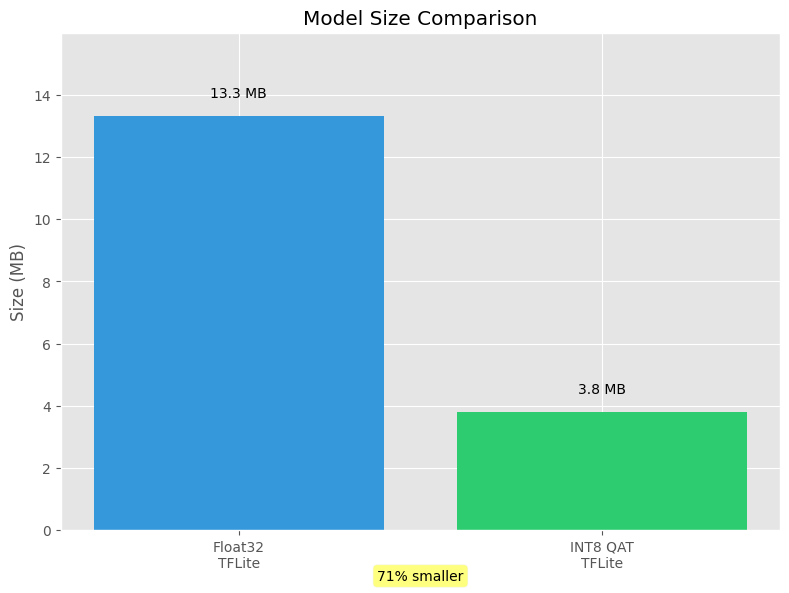

In [14]:
# Visualize the comparison
plt.figure(figsize=(8, 6))
models = ['Float32\nTFLite', 'INT8 QAT\nTFLite']
sizes = [float_size, quant_size]
colors = ['#3498db', '#2ecc71']

bars = plt.bar(models, sizes, color=colors)
plt.ylabel('Size (MB)')
plt.title('Model Size Comparison')

# Add value labels on bars
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{size:.1f} MB', ha='center', va='bottom')

# Add reduction percentage at the bottom of the plot
plt.text(0.5, -0.1, f'{reduction:.0f}% smaller', 
         ha='center', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.ylim(0, max(sizes) * 1.2)  # Dynamically adjust the y-axis to fit the labels
plt.tight_layout()
plt.show()

> **Evaluation brainstorm**: You should have confirmed the 4x size reduction, but what other evaluations would you run before deploying to wildlife cameras?
> 
> Consider testing:
> - Inference speed on actual NPU hardware vs CPU
> - Accuracy on specific rare bird species images
> - Battery consumption during continuous operation
> - Model behavior in extreme temperatures
> - Performance with partially occluded animals
> - Robustness to different lighting conditions
> 
> Which metrics matter most for your conservation goals? How would you prioritize testing given limited field deployment time?

## Conclusion

In this exercise, you've learned how to:
* Convert a standard model for quantization-aware training using fake quantization operations
* Fine-tune models while simulating INT8 constraints to maintain accuracy
* Define representative datasets for optimal TFLite conversion
* Create INT8-optimized models ready for edge hardware acceleration
* Evaluate quantization trade-offs on model size

These skills allow you to create models specifically optimized for integer-only hardware from the training phase, rather than as an afterthought. QAT is particularly valuable when targeting specialized NPUs or when specific accuracy requirements (like rare species detection) demand the best possible INT8 performance.

> **🚀 Bonus exploration:** Why not dive deeper into the example to learn even more details about QAT? You could:
>    - Experiment with more epochs for fine-tuning QAT, and use your actual wildlife dataset, especially images of the rare and similar-looking common birds.
>    - Implement a full evaluation pipeline to compare the accuracy and on-device latency of the QAT TFLite model against the original, float TFLite, and PTQ TFLite models using your actual wildlife dataset and target camera hardware.
>    - Explore different QAT configurations and schemes available in the TensorFlow Model Optimization Toolkit.
>    - Investigate the impact of different `inference_input_type` and `inference_output_type` (e.g., `tf.uint8` vs `tf.int8`) if your hardware has specific preferences.